In [16]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc
)
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
from scipy.stats import entropy, skew, kurtosis
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

RANDOM_STATE = 42
WINDOW_SIZE = 512
STEP_SIZE = 512
BASE_PATH = r"C:\DIGITAL TWIN\dataset"


In [17]:
files_info = {
    "Healthy": os.path.join(BASE_PATH, "test6_healthy_D40_S0label.csv"),
    "Suction blockage at 10°": os.path.join(BASE_PATH, "test6_S10_D40label.csv"),
    "Suction blockage at 20°": os.path.join(BASE_PATH, "test6_S20_D40label.csv"),
    "Suction blockage at 30°": os.path.join(BASE_PATH, "test6_S30_D40label.csv"),
    "Suction blockage at 40°": os.path.join(BASE_PATH, "test6_SB40_D40label.csv"),
}

all_data = []
for label, path in files_info.items():
    df = pd.read_csv(path, encoding='latin1')
    df["Class"] = label
    all_data.append(df)

data = pd.concat(all_data, ignore_index=True)
print(f"✅ Loaded {len(data)} total rows from all files")

required_columns = {"X Axis", "Y Axis", "Z Axis"}
assert required_columns.issubset(data.columns), f"Missing columns: {required_columns - set(data.columns)}"


✅ Loaded 1536000 total rows from all files


In [18]:
def extract_frequency_features(signal, axis):
    fft_vals = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal))
    spectrum = np.abs(fft_vals[:len(signal)//2])
    power = spectrum ** 2

    return {
        f"{axis}_fft_max": np.max(spectrum),
        f"{axis}_fft_mean": np.mean(spectrum),
        f"{axis}_fft_peak_freq": freqs[np.argmax(spectrum)],
        f"{axis}_fft_total_power": np.sum(power),
        f"{axis}_fft_centroid": np.sum(freqs[:len(signal)//2] * spectrum) / np.sum(spectrum),
        f"{axis}_fft_spread": np.std(spectrum),
        f"{axis}_fft_entropy": entropy(spectrum + 1e-6),
    }

def extract_features_from_window(window):
    feat = {}
    for axis in ["X Axis", "Y Axis", "Z Axis"]:
        signal = window[axis].values
        hist = np.histogram(signal, bins=10)[0] + 1
        peak = np.max(np.abs(signal))
        rms = np.sqrt(np.mean(signal ** 2))
        mav = np.mean(np.abs(signal))
        mean = np.mean(signal)
        std = np.std(signal)
        var = np.var(signal)

        feat.update({
            f"{axis}_mean": mean,
            f"{axis}_std": std,
            f"{axis}_min": np.min(signal),
            f"{axis}_max": np.max(signal),
            f"{axis}_skew": skew(signal),
            f"{axis}_kurtosis": kurtosis(signal),
            f"{axis}_entropy": entropy(hist),
            f"{axis}_abs_mean": mav,
            f"{axis}_energy": np.sum(signal ** 2),
            f"{axis}_var": var,
            f"{axis}_rms": rms,
            f"{axis}_mav": mav,
            f"{axis}_ptp": np.ptp(signal),
            f"{axis}_crest_factor": peak / rms if rms != 0 else 0,
            f"{axis}_impulse_factor": peak / mean if mean != 0 else 0,
            f"{axis}_shape_factor": rms / mav if mav != 0 else 0,
            f"{axis}_margin_factor": peak / np.sqrt(mean**2) if mean != 0 else 0,
        })

        feat.update(extract_frequency_features(signal, axis))
    return feat


In [19]:
features = []
for label in data["Class"].unique():
    class_df = data[data["Class"] == label]
    for start in range(0, len(class_df) - WINDOW_SIZE + 1, STEP_SIZE):
        window = class_df.iloc[start:start + WINDOW_SIZE]
        feat = extract_features_from_window(window)
        feat["Class"] = label
        features.append(feat)

features_df = pd.DataFrame(features)
print(f"\n✅ Extracted {len(features_df)} windows.")



✅ Extracted 3000 windows.


In [20]:
features_df["Target"] = features_df["Class"].astype("category").cat.codes
label_mapping = dict(enumerate(features_df["Class"].astype("category").cat.categories))
print("\n📊 Label Mapping:")
print(label_mapping)



📊 Label Mapping:
{0: 'Healthy', 1: 'Suction blockage at 10°', 2: 'Suction blockage at 20°', 3: 'Suction blockage at 30°', 4: 'Suction blockage at 40°'}


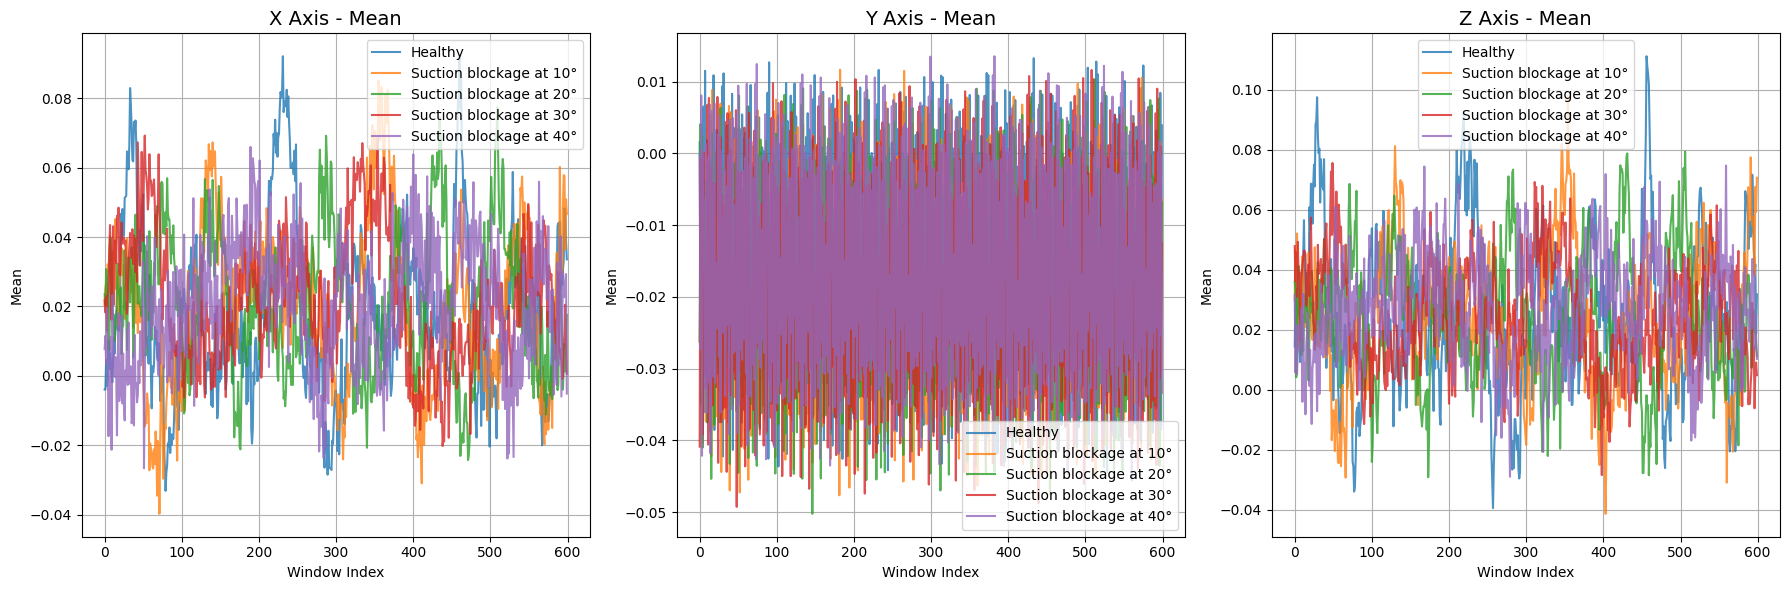

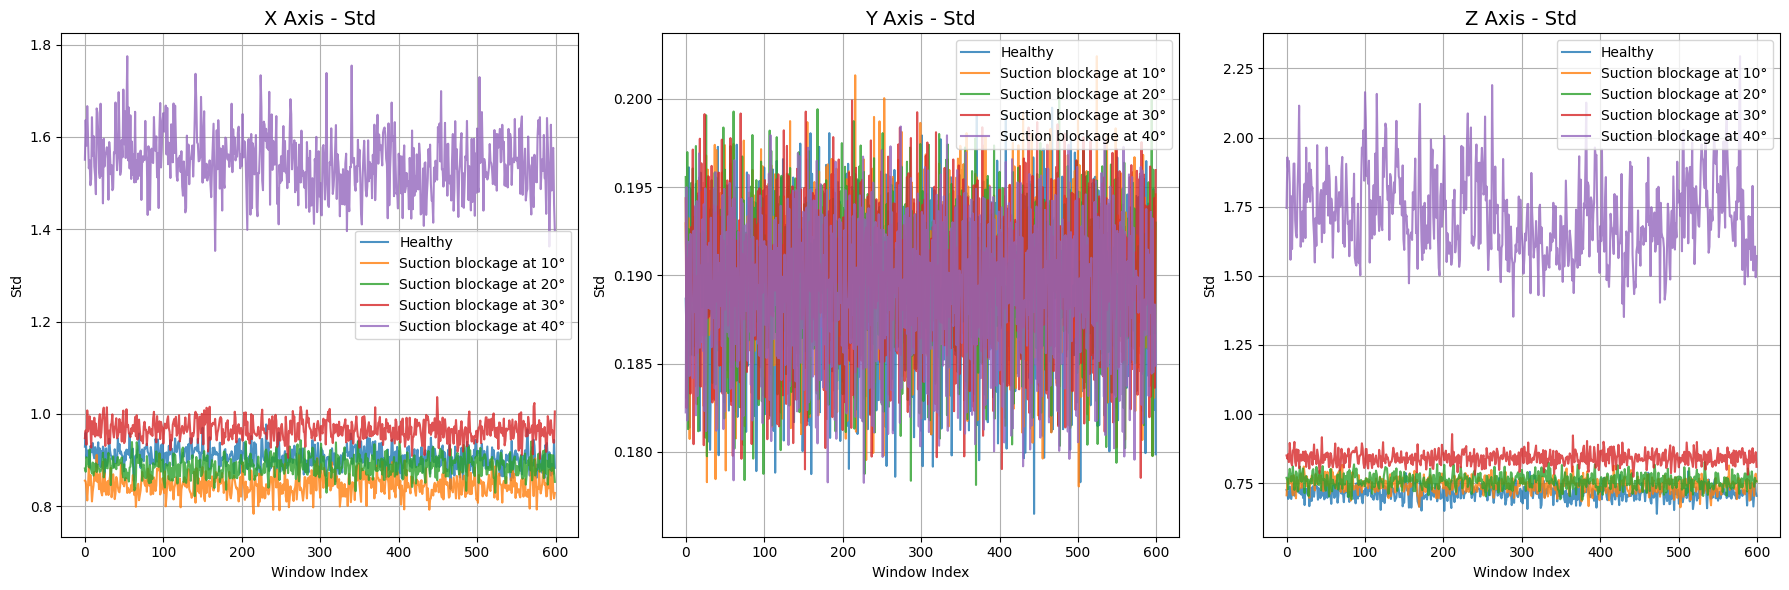

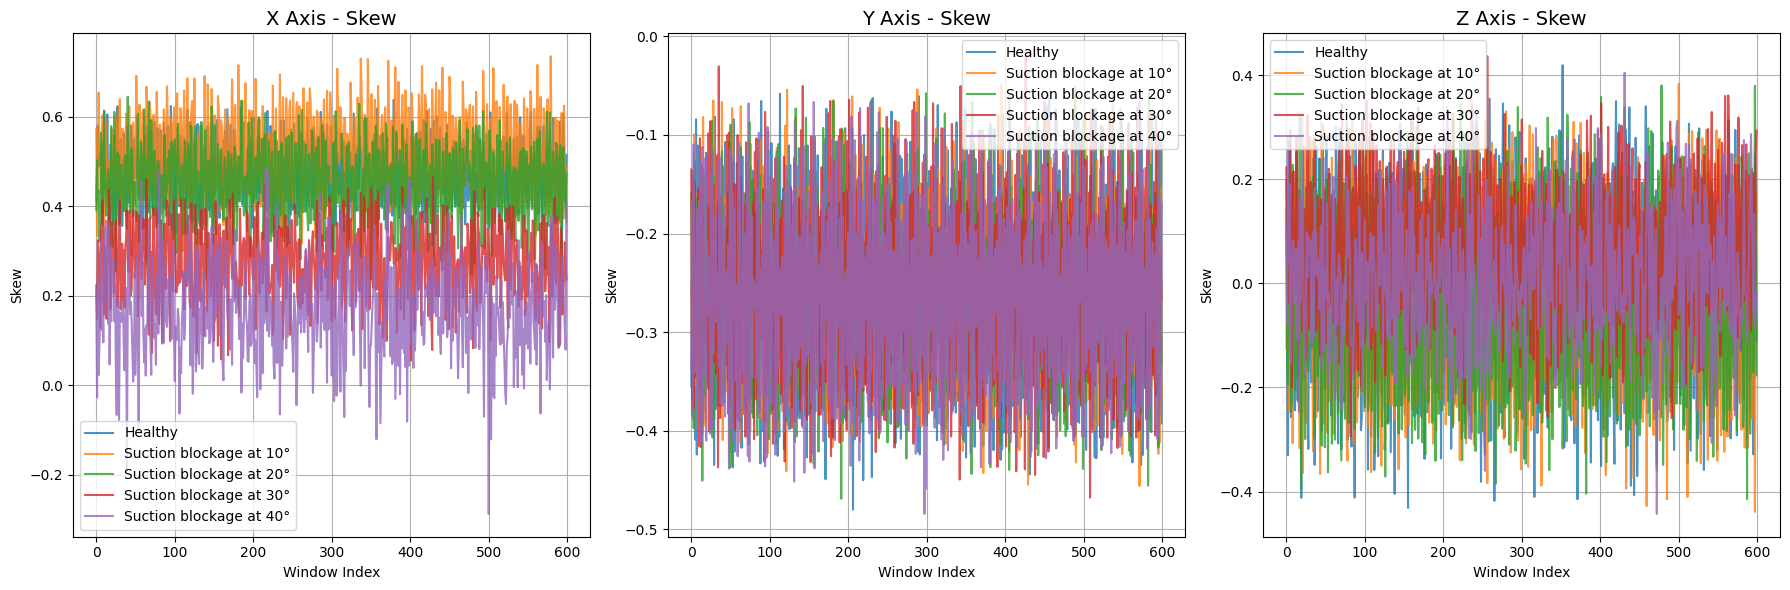

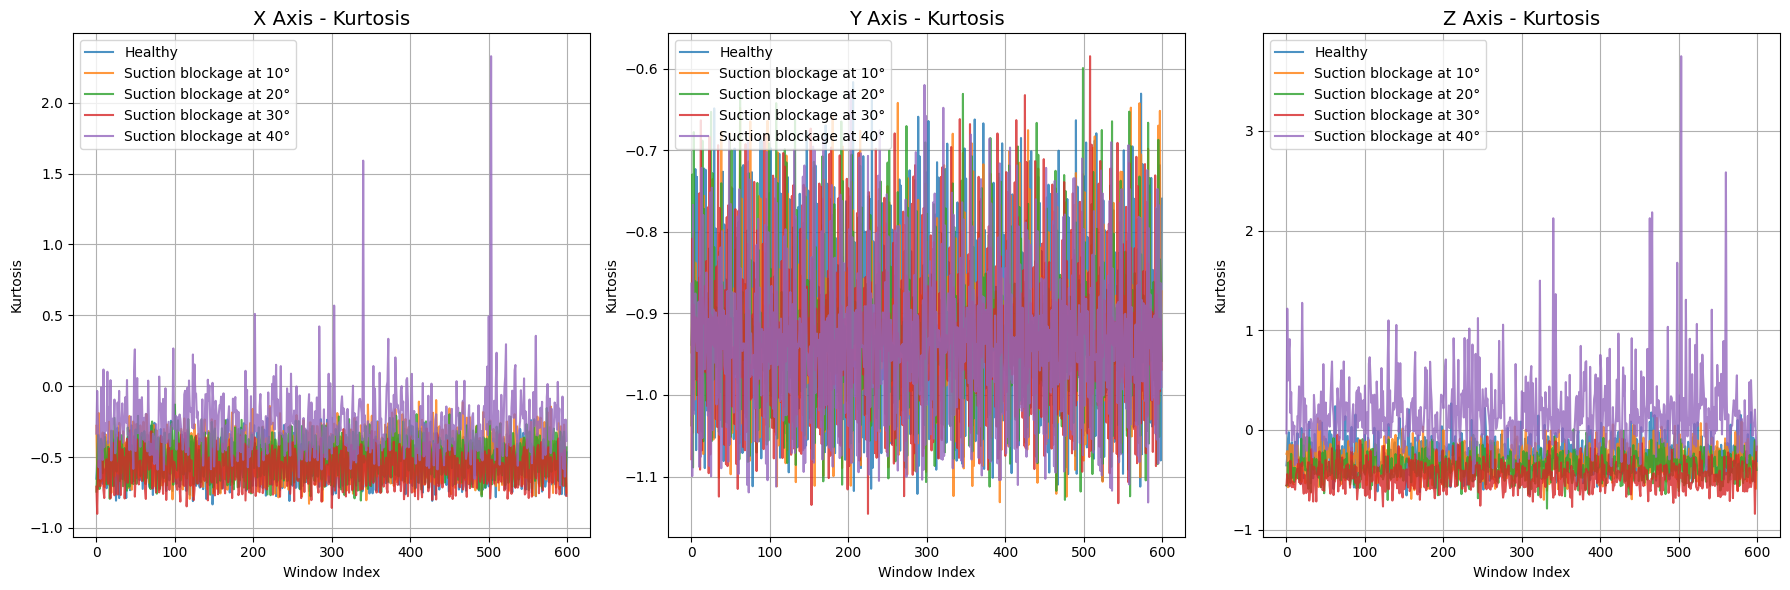

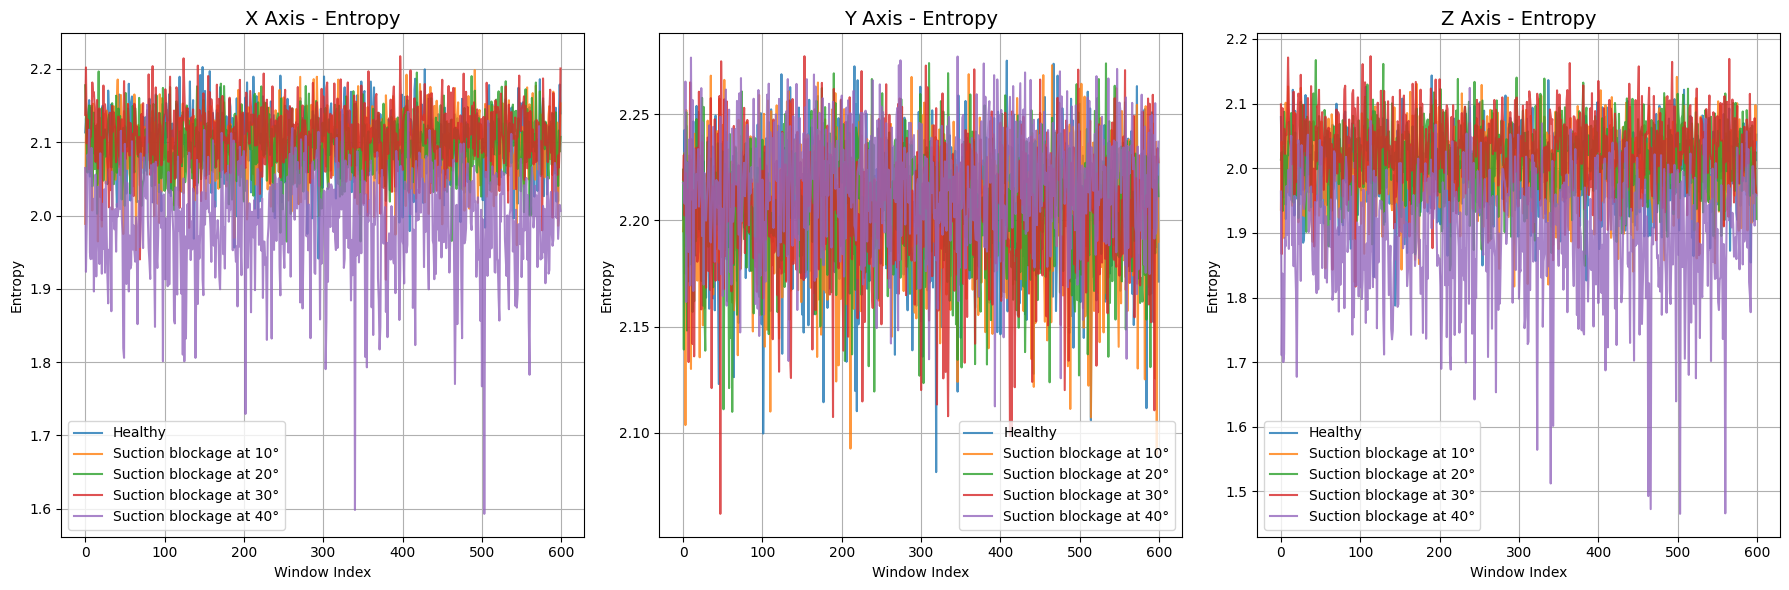

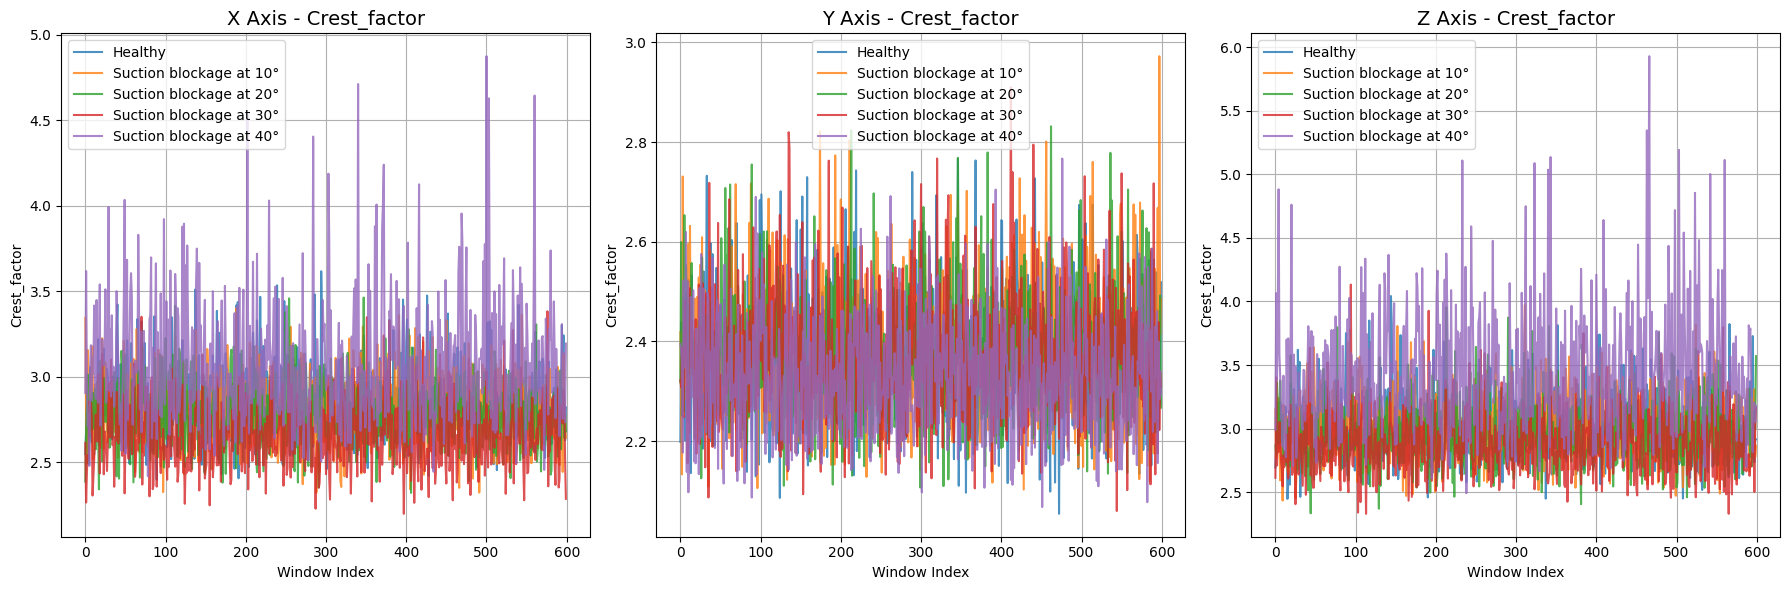

In [21]:
# Choose statistical features to plot
selected_features = [
    "mean", "std", "skew", "kurtosis", "entropy", "crest_factor"
]

# Function to plot line plots per feature and axis
def plot_feature_lineplots(features_df, selected_features, label_mapping):
    axes = ["X Axis", "Y Axis", "Z Axis"]
    class_labels = features_df["Class"].unique()
    
    for feat in selected_features:
        plt.figure(figsize=(18, 6))
        for axis in axes:
            plt.subplot(1, 3, axes.index(axis)+1)
            for label in class_labels:
                subset = features_df[features_df["Class"] == label]
                y = subset[f"{axis}_{feat}"].values
                x = np.arange(len(y))
                plt.plot(x, y, label=label, alpha=0.8)
            
            plt.title(f"{axis} - {feat.capitalize()}", fontsize=14)
            plt.xlabel("Window Index")
            plt.ylabel(f"{feat.capitalize()}")
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout()
        plt.show()

# Plot features (like Figure 8 in paper)
plot_feature_lineplots(features_df, selected_features, label_mapping)


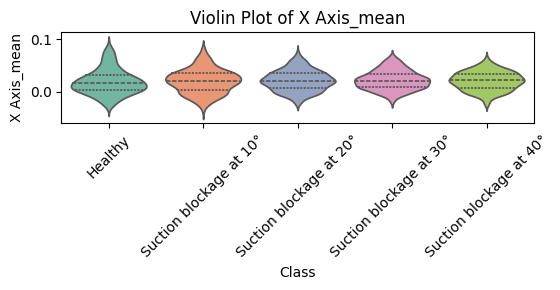

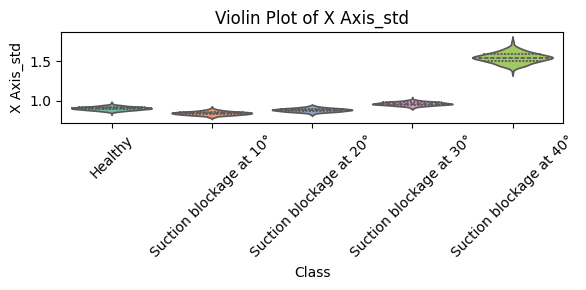

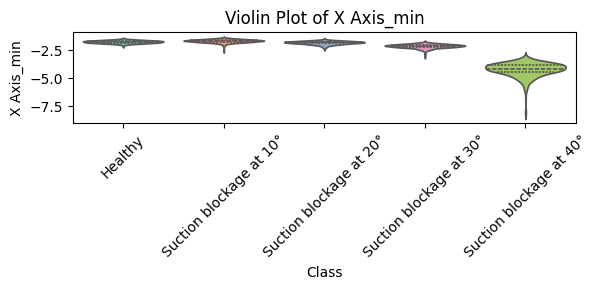

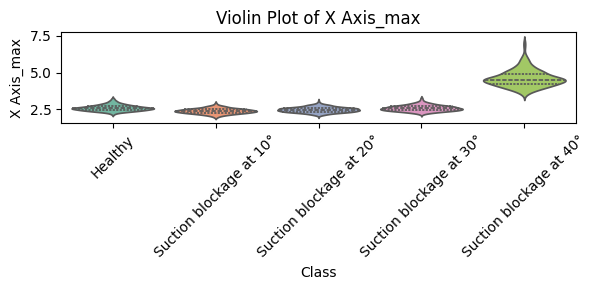

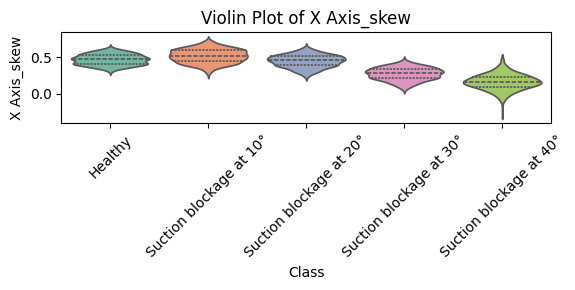

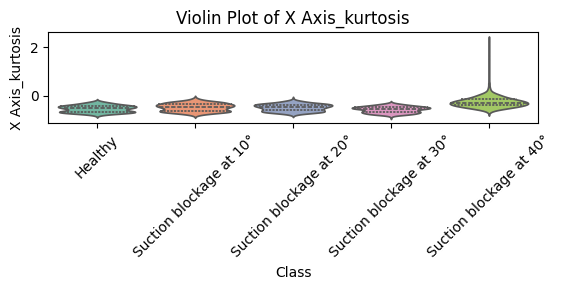

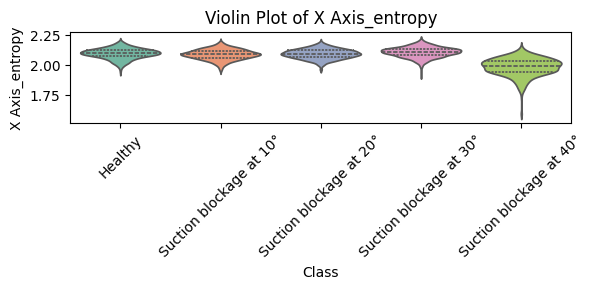

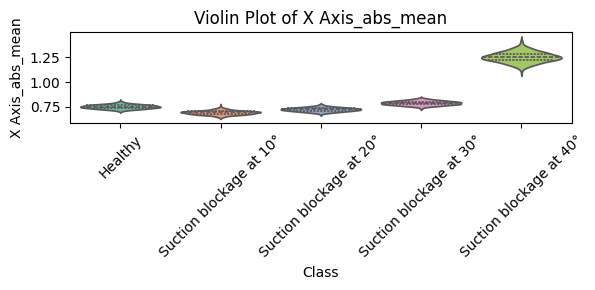

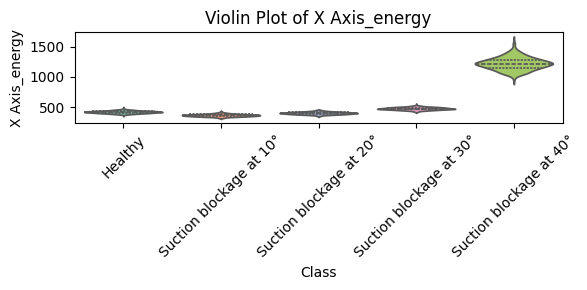

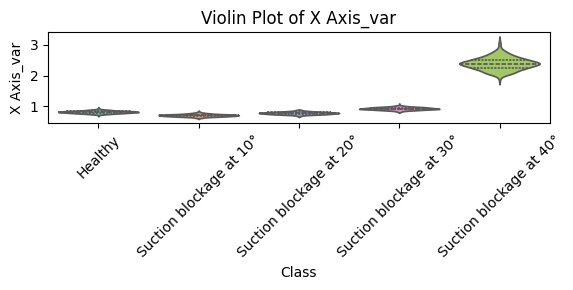

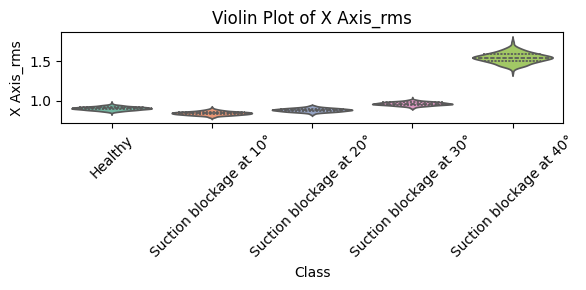

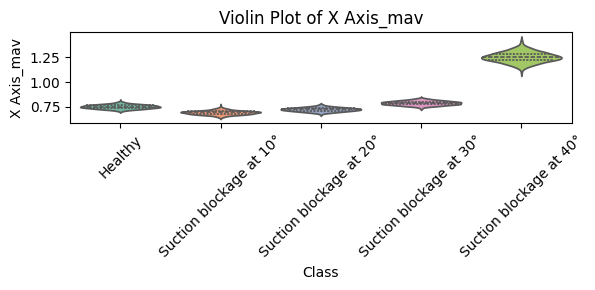

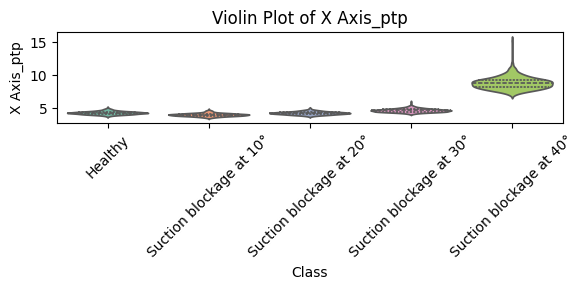

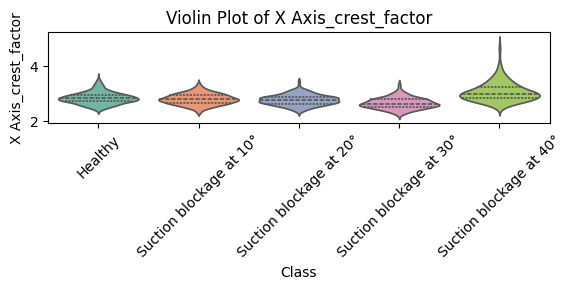

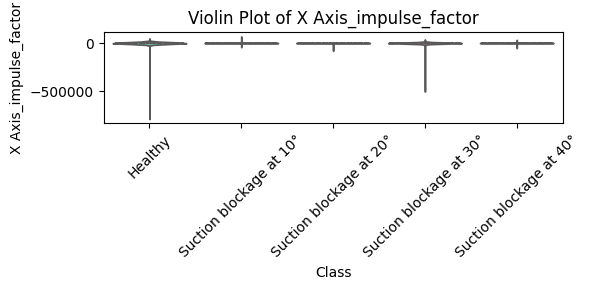

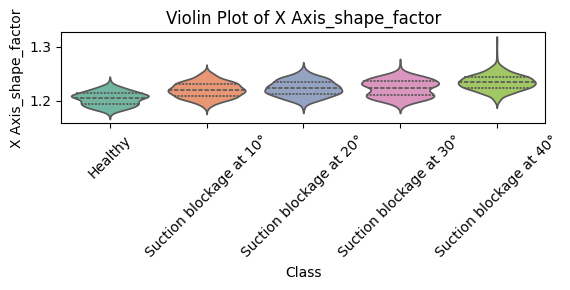

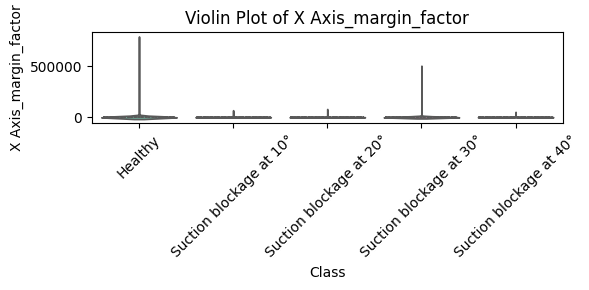

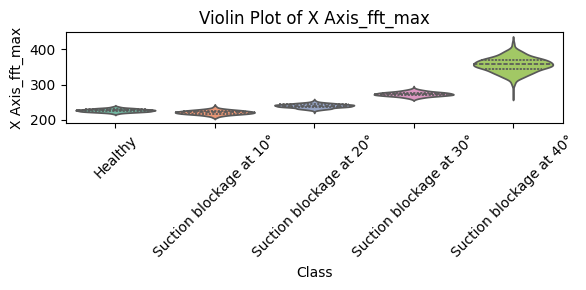

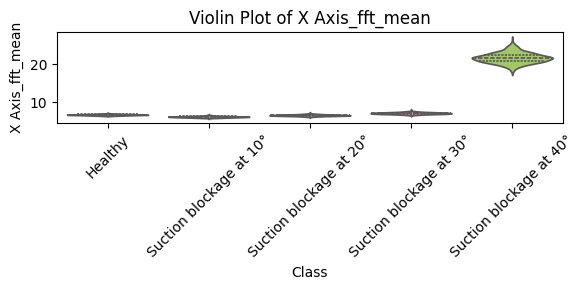

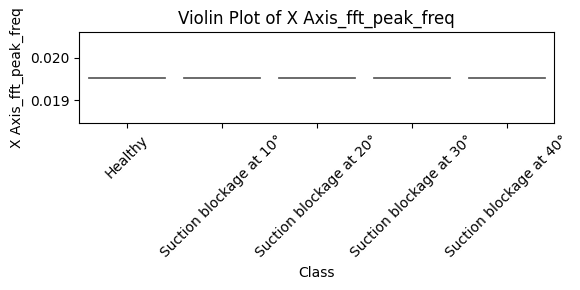

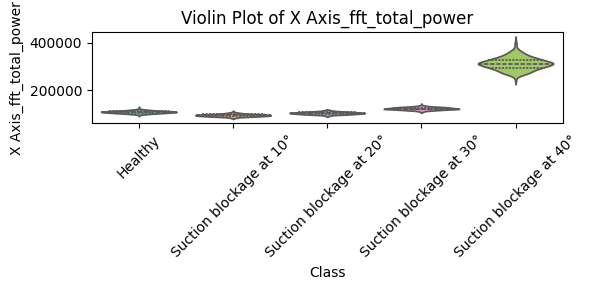

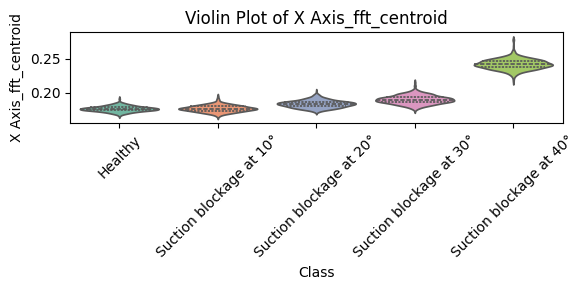

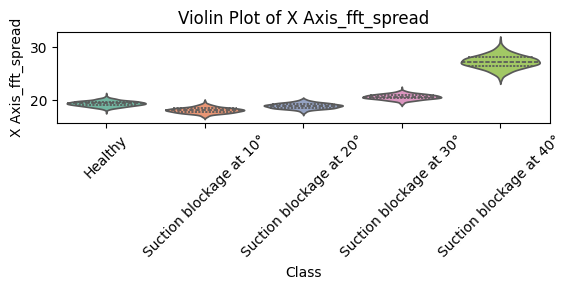

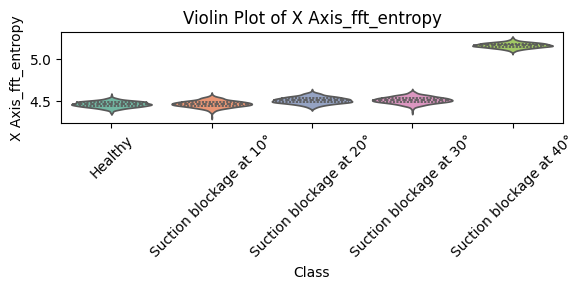

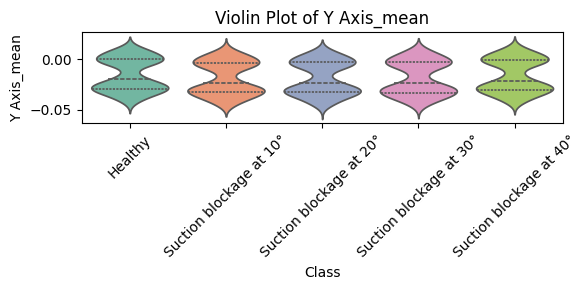

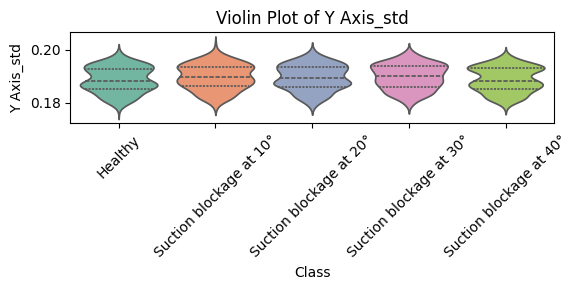

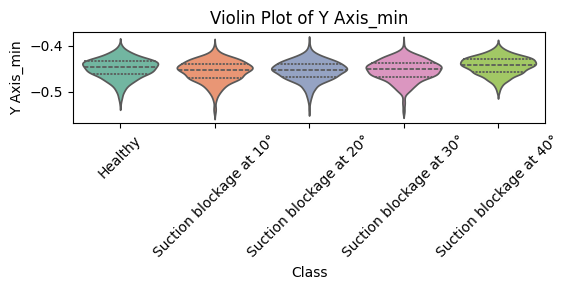

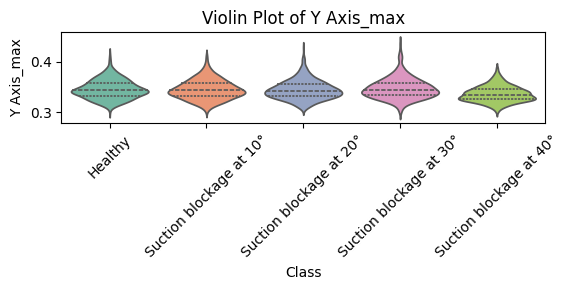

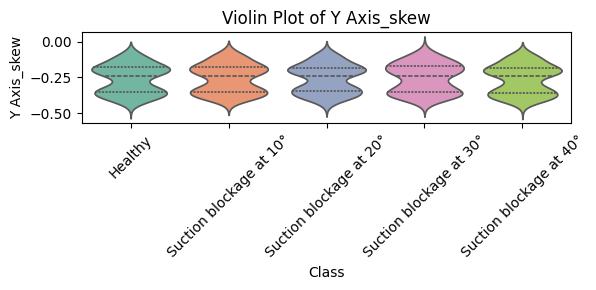

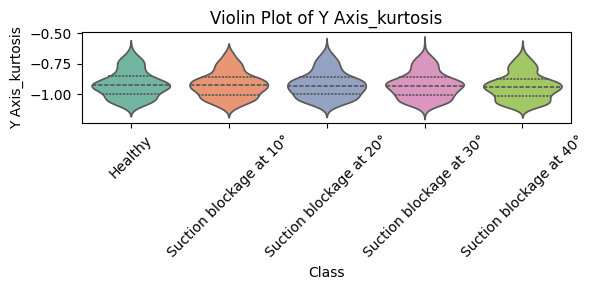

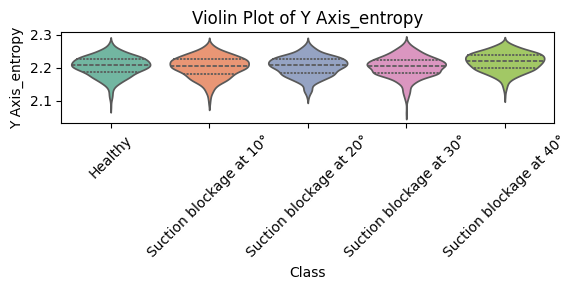

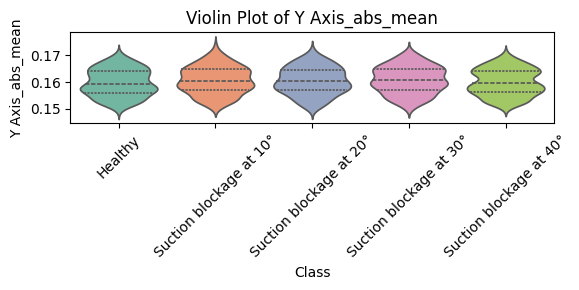

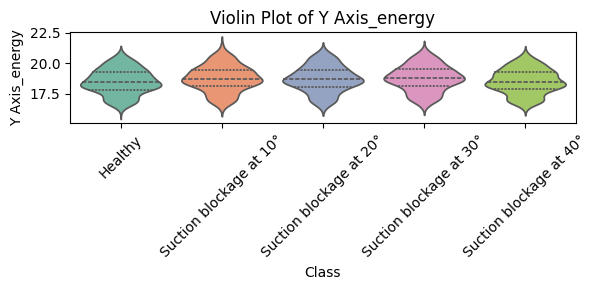

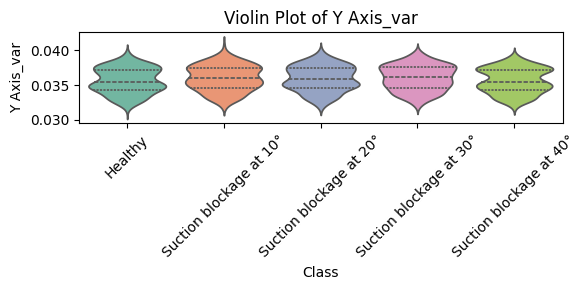

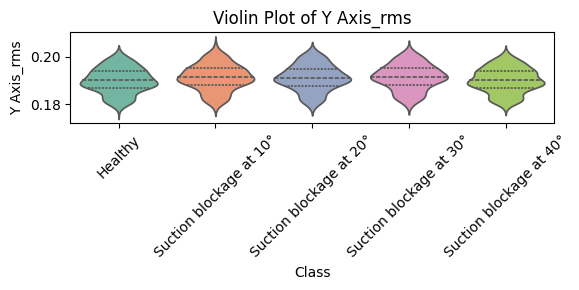

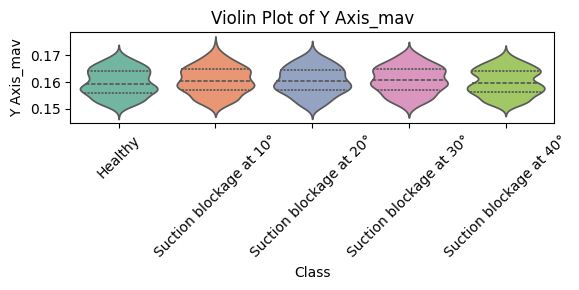

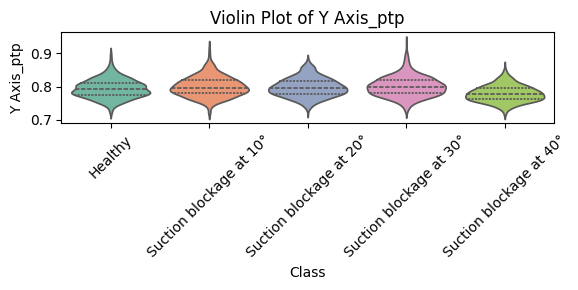

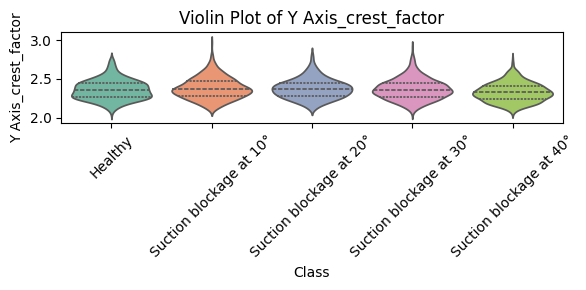

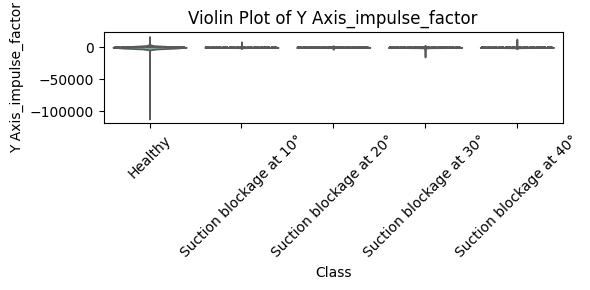

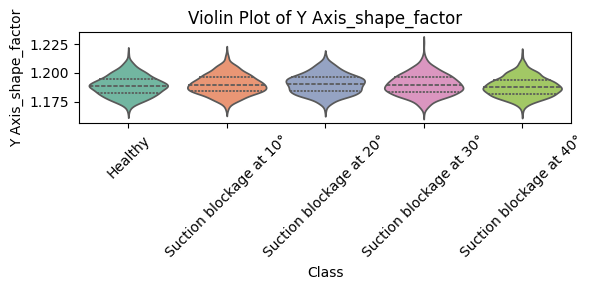

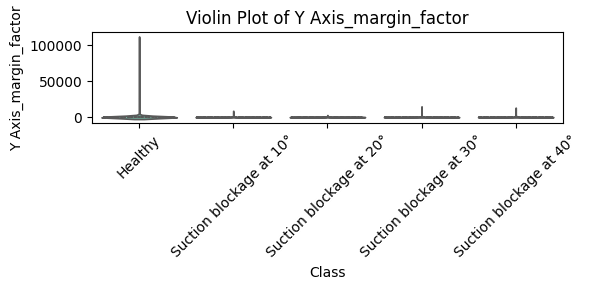

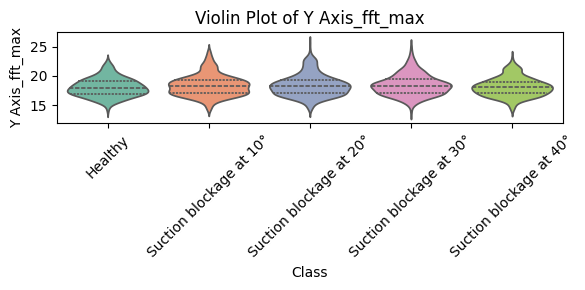

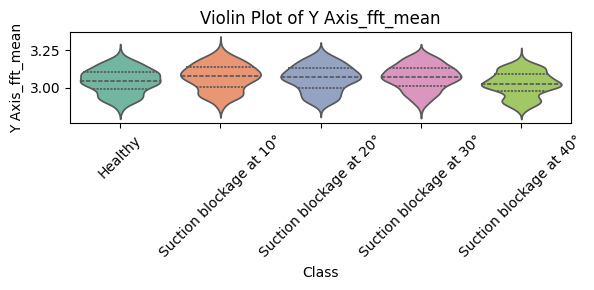

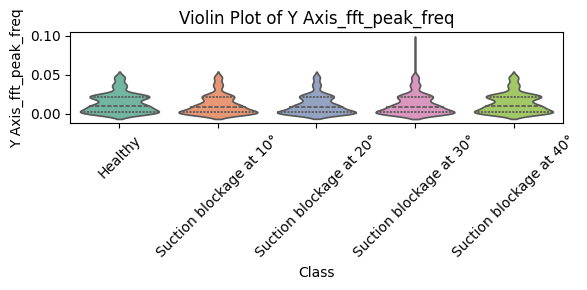

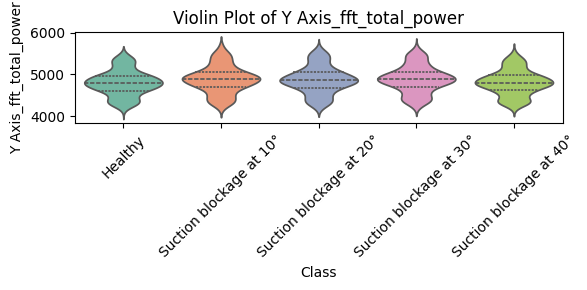

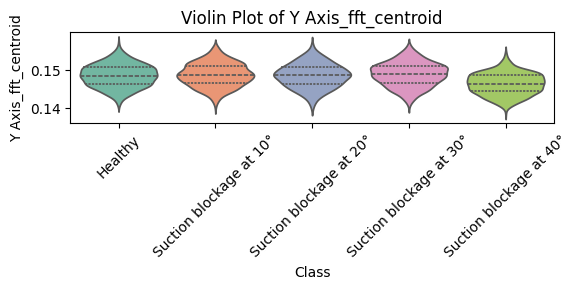

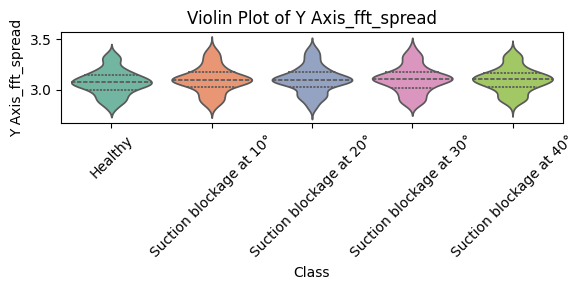

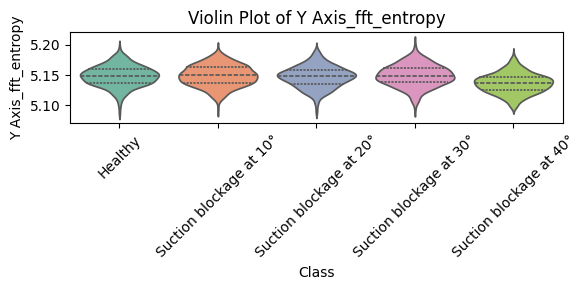

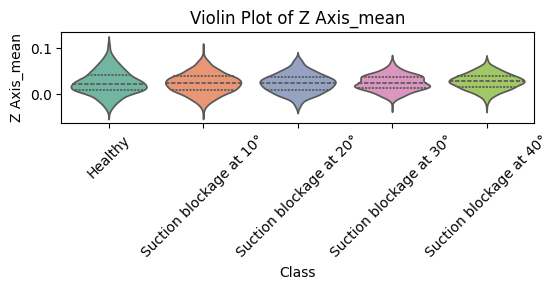

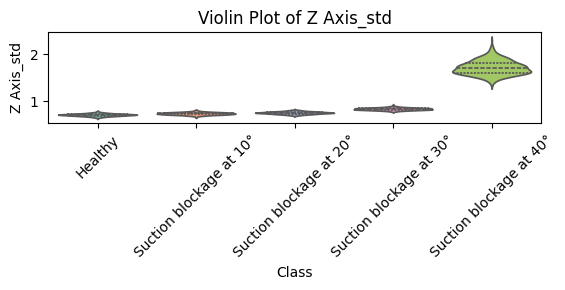

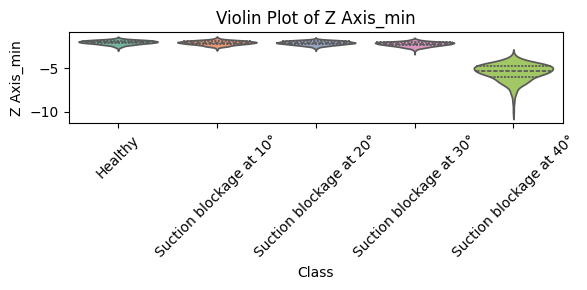

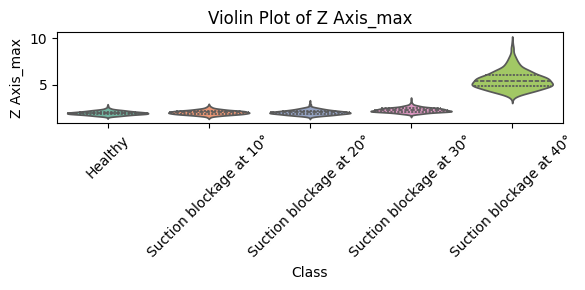

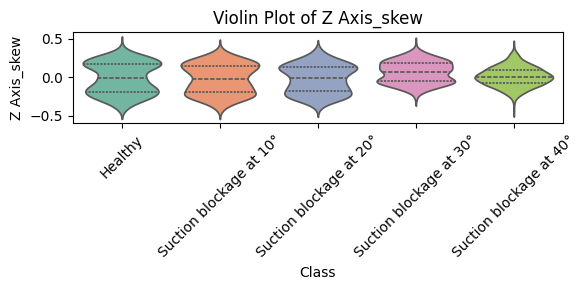

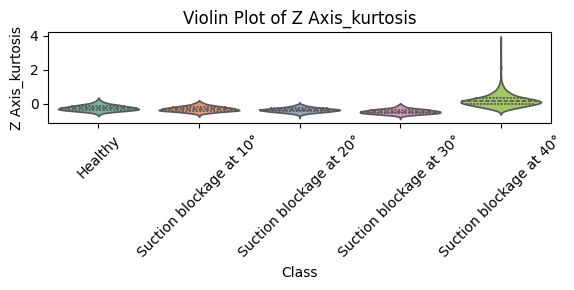

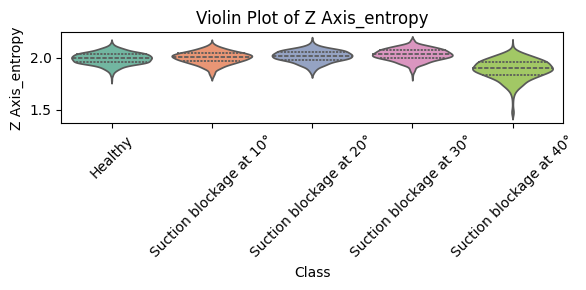

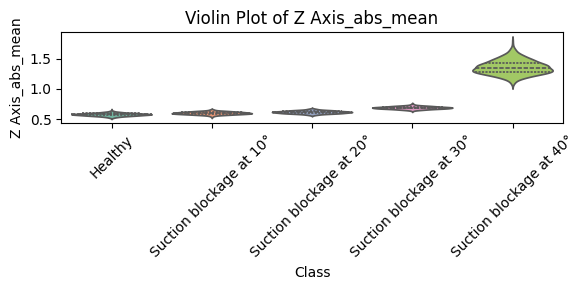

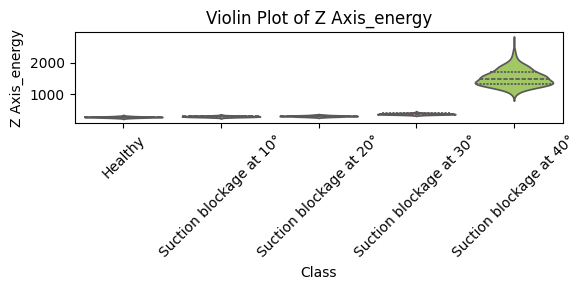

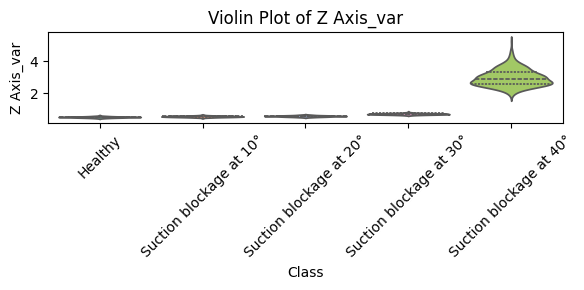

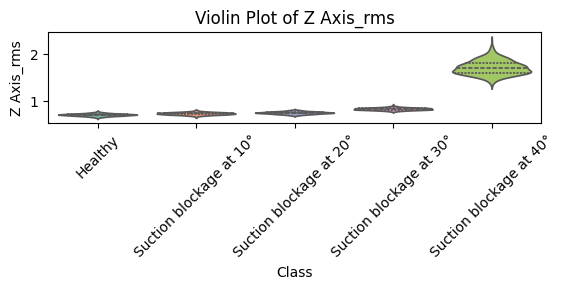

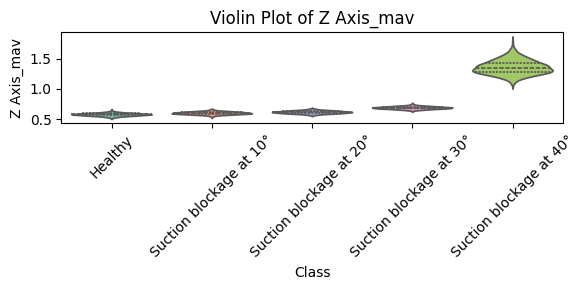

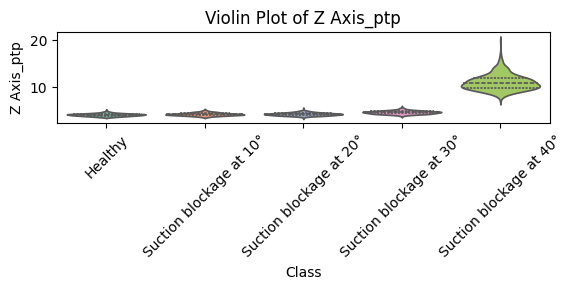

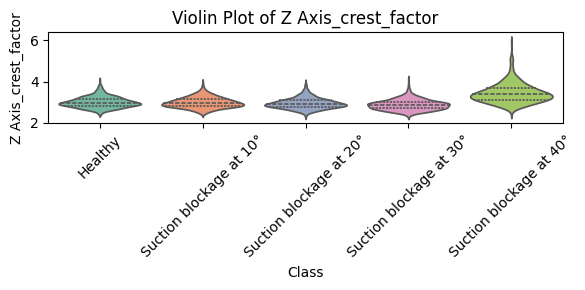

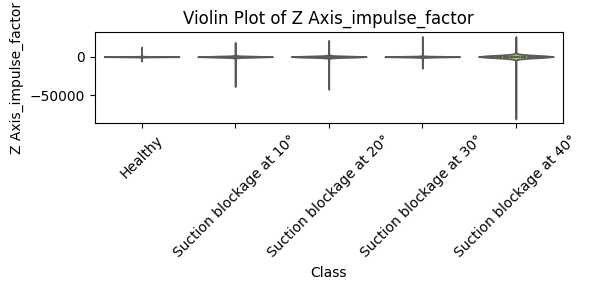

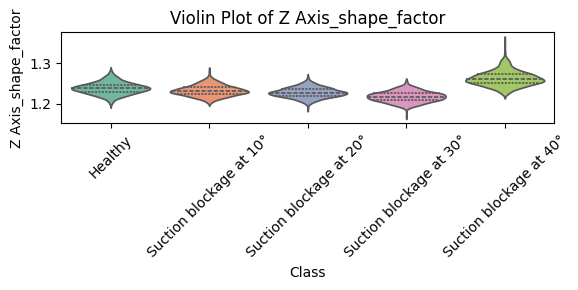

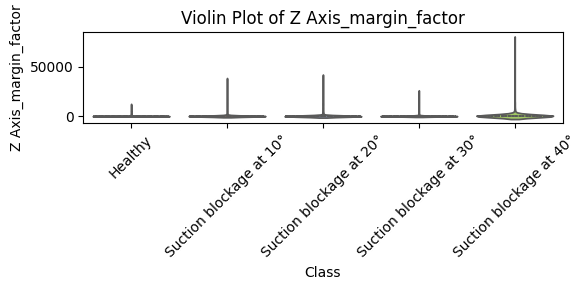

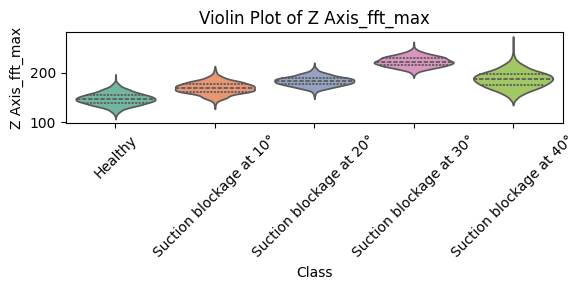

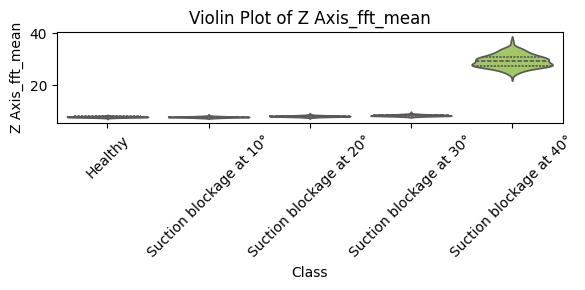

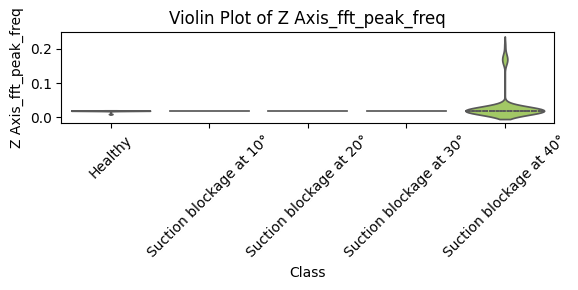

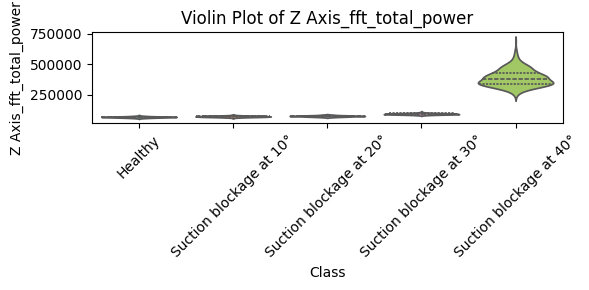

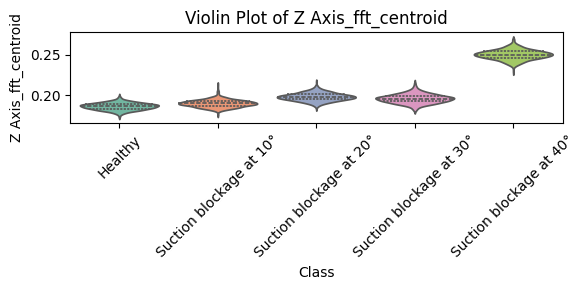

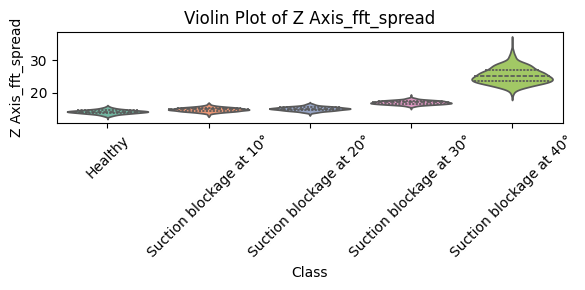

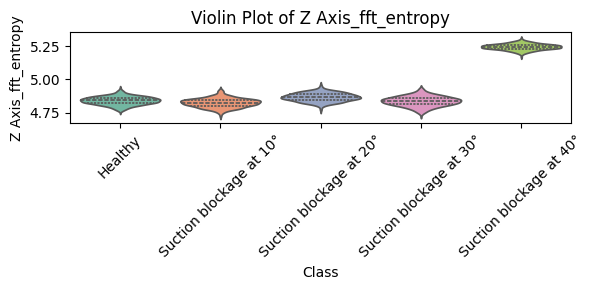

In [22]:
# You can choose either violinplot or stripplot (scatter-like on class axis)
for col in features_df.columns:
    if col not in ["Class", "Target"]:
        plt.figure(figsize=(6, 3))
        sns.violinplot(x="Class", y=col, data=features_df, inner="quart", palette="Set2")
        plt.title(f"Violin Plot of {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


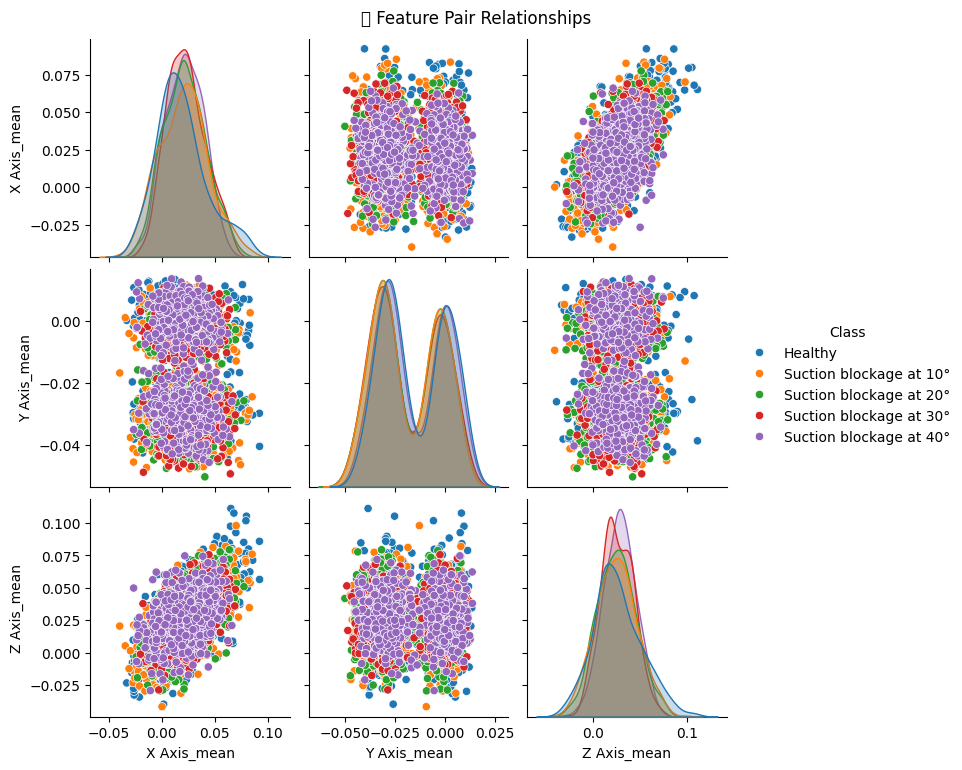

In [23]:
key_feats = ["X Axis_mean", "Y Axis_mean", "Z Axis_mean"]
sns.pairplot(features_df[key_feats + ["Class"]], hue="Class", palette="tab10")
plt.suptitle("📈 Feature Pair Relationships", y=1.02)
plt.show()


In [24]:
X = features_df.drop(columns=["Class", "Target"])
y = features_df["Target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)

print(f"\n✅ Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



✅ Training samples: 2100, Testing samples: 900


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

def evaluate_model(y_true, y_pred, y_proba, label_names=None, print_metrics=True, save_results=False):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)

    classes = np.unique(y_true)
    num_classes = len(classes)

    if label_names is None:
        label_names = [str(i) for i in classes]

    # Binarize labels
    if num_classes == 2:
        y_true_bin = label_binarize(y_true, classes=[0, 1])
    else:
        y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

    # Specificity calculation
    specificity = []
    for i in range(num_classes):
        true_class = y_true_bin[:, i]
        pred_class = (y_pred == i).astype(int)
        cm = confusion_matrix(true_class, pred_class)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        else:
            spec = 0
        specificity.append(spec)

    # Metrics
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    try:
        roc_auc = roc_auc_score(y_true_bin, y_proba, average='weighted', multi_class='ovr')
    except:
        roc_auc = float('nan')

    pr_auc_list = []
    for i in range(num_classes):
        try:
            precision_curve, recall_curve, _ = precision_recall_curve(y_true_bin[:, i], y_proba[:, i])
            pr_auc = auc(recall_curve, precision_curve)
            pr_auc_list.append(pr_auc)
        except:
            pr_auc_list.append(0)

    pr_auc_mean = np.mean(pr_auc_list)

    # === Print Results ===
    if print_metrics:
        print("\n📊 Model Evaluation Report:")
        print(f"✔️ Accuracy: {accuracy_score(y_true, y_pred):.4f}")
        print(f"✔️ Precision: {precision:.4f}")
        print(f"✔️ Recall (TPR): {recall:.4f}")
        print(f"✔️ Specificity (TNR): {np.mean(specificity):.4f}")
        print(f"✔️ F1 Score: {f1:.4f}")
        print(f"✔️ ROC–AUC: {roc_auc:.4f}")
        print(f"✔️ PR–AUC: {pr_auc_mean:.4f}")

    # === Confusion Matrix Heatmap ===
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # === Save metrics to CSV ===
    if save_results:
        metrics_dict = {
            "Accuracy": [accuracy_score(y_true, y_pred)],
            "Precision": [precision],
            "Recall": [recall],
            "Specificity": [np.mean(specificity)],
            "F1 Score": [f1],
            "ROC–AUC": [roc_auc],
            "PR–AUC": [pr_auc_mean]
        }
        metrics_df = pd.DataFrame(metrics_dict)
        metrics_df.to_csv("model_metrics.csv", index=False)
        cm_df.to_csv("confusion_matrix.csv")
        print("✅ Metrics and Confusion Matrix saved to disk.")


In [26]:
def train_and_evaluate(X_train, y_train, X_test, y_test, smote=False):
    if smote:
        sm = SMOTE(random_state=RANDOM_STATE)
        X_train, y_train = sm.fit_resample(X_train, y_train)
        print("\n✅ SMOTE Applied")

    svm_params = {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    }

    grid = GridSearchCV(SVC(probability=True), svm_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    best_svm = grid.best_estimator_

    y_pred = best_svm.predict(X_test)
    y_proba = best_svm.predict_proba(X_test)

    print(f"\n📊 Best SVM Parameters: {grid.best_params_}")
    print(classification_report(y_test, y_pred, target_names=label_mapping.values()))
    evaluate_model(y_test, y_pred, y_proba)



🔍 Analysis WITHOUT SMOTE
Fitting 3 folds for each of 12 candidates, totalling 36 fits

📊 Best SVM Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
                         precision    recall  f1-score   support

                Healthy       0.99      0.99      0.99       180
Suction blockage at 10°       0.98      0.99      0.99       180
Suction blockage at 20°       0.99      0.99      0.99       180
Suction blockage at 30°       1.00      1.00      1.00       180
Suction blockage at 40°       1.00      1.00      1.00       180

               accuracy                           0.99       900
              macro avg       0.99      0.99      0.99       900
           weighted avg       0.99      0.99      0.99       900


📊 Model Evaluation Report:
✔️ Accuracy: 0.9944
✔️ Precision: 0.9945
✔️ Recall (TPR): 0.9944
✔️ Specificity (TNR): 0.9986
✔️ F1 Score: 0.9944
✔️ ROC–AUC: 0.9999
✔️ PR–AUC: 0.9997


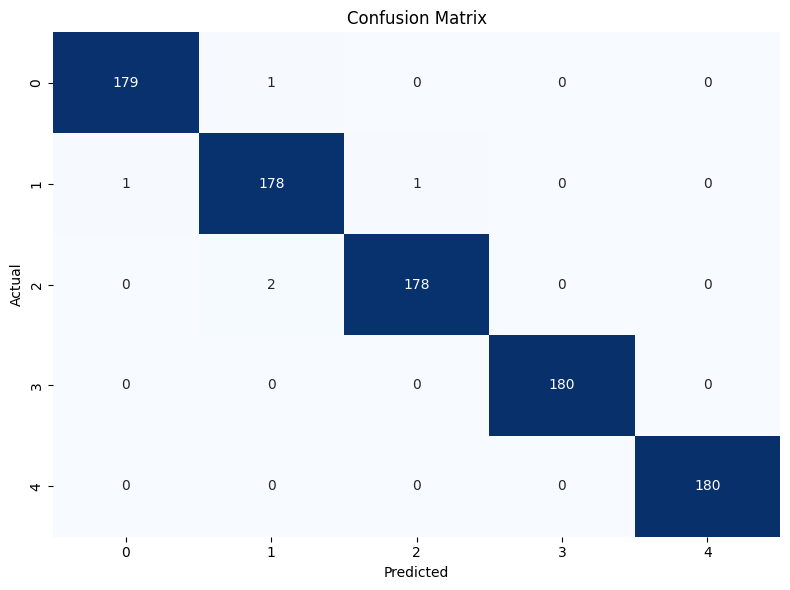

In [27]:
print("\n🔍 Analysis WITHOUT SMOTE")
train_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, smote=False)





🔍 Analysis WITH SMOTE

✅ SMOTE Applied
Fitting 3 folds for each of 12 candidates, totalling 36 fits

📊 Best SVM Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
                         precision    recall  f1-score   support

                Healthy       0.99      0.99      0.99       180
Suction blockage at 10°       0.98      0.99      0.99       180
Suction blockage at 20°       0.99      0.99      0.99       180
Suction blockage at 30°       1.00      1.00      1.00       180
Suction blockage at 40°       1.00      1.00      1.00       180

               accuracy                           0.99       900
              macro avg       0.99      0.99      0.99       900
           weighted avg       0.99      0.99      0.99       900


📊 Model Evaluation Report:
✔️ Accuracy: 0.9944
✔️ Precision: 0.9945
✔️ Recall (TPR): 0.9944
✔️ Specificity (TNR): 0.9986
✔️ F1 Score: 0.9944
✔️ ROC–AUC: 0.9999
✔️ PR–AUC: 0.9997


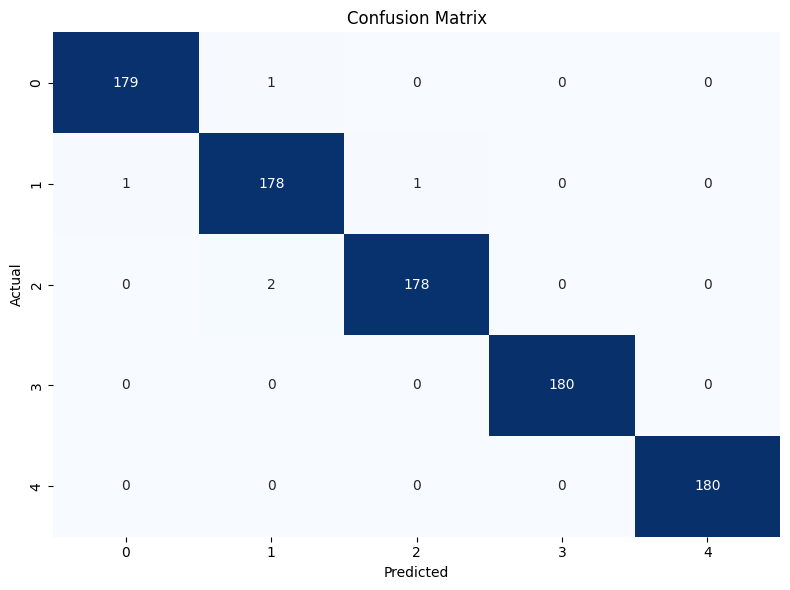

In [28]:
print("\n🔍 Analysis WITH SMOTE")
train_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, smote=True)

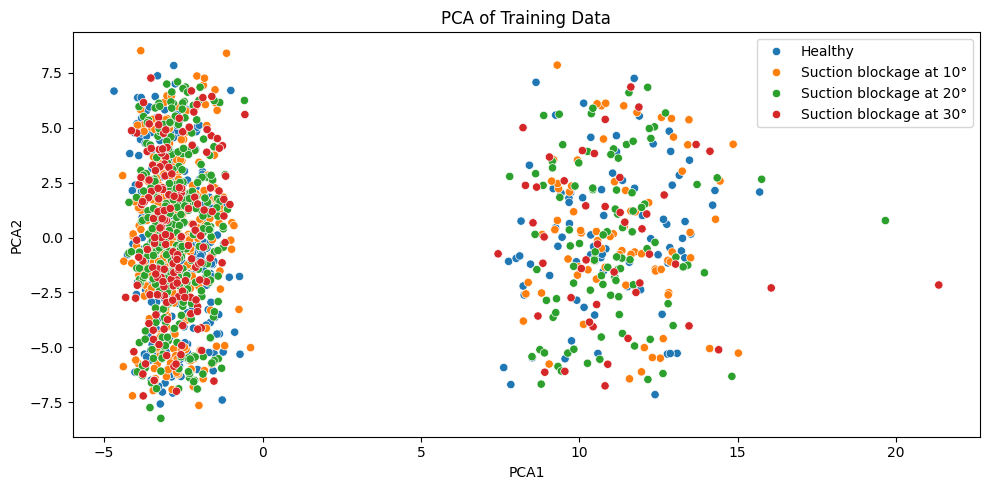

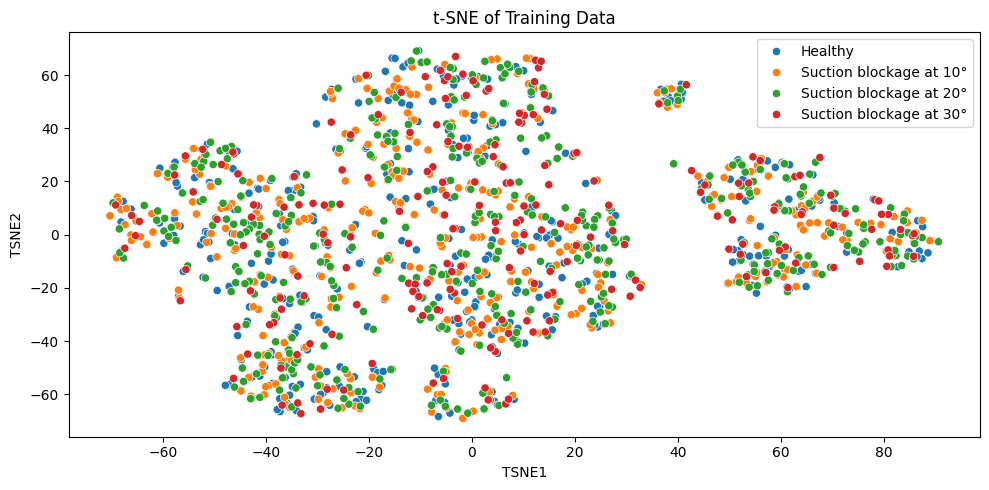

In [29]:
# PCA
pca = PCA(n_components=2, random_state=RANDOM_STATE)
pca_data = pca.fit_transform(X_train_scaled)
pca_df = pd.DataFrame(pca_data, columns=["PCA1", "PCA2"])
pca_df["Label"] = y_train.map(label_mapping)

plt.figure(figsize=(10, 5))
sns.scatterplot(data=pca_df, x="PCA1", y="PCA2", hue="Label", palette="tab10")
plt.title("PCA of Training Data")
plt.legend()
plt.tight_layout()
plt.show()

# t-SNE
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=10)
tsne_data = tsne.fit_transform(X_train_scaled)
tsne_df = pd.DataFrame(tsne_data, columns=["TSNE1", "TSNE2"])
tsne_df["Label"] = y_train.map(label_mapping)

plt.figure(figsize=(10, 5))
sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue="Label", palette="tab10")
plt.title("t-SNE of Training Data")
plt.legend()
plt.tight_layout()
plt.show()
